## Библиотеки

Первым этапом анализа данных и разработки модели является импортирование нужных библиотек

In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [27]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

## Датасет

Прежде чем разбираться с моделями, нам стоит происследовать правильно ли загружены данные и а так же рассмотреть их распредиеление и проверить наличие "аномалий".

In [28]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

In [29]:
df_train.sort_index(inplace=True)
df_train.reset_index(drop=True,inplace=True)
df_train.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
0,12/31/2020/00:20,8.56239,74.5,0.08240,0.062,0.100,69837.318588
1,12/31/2020/00:30,8.36463,75.0,0.08549,0.091,0.096,67453.909053
2,12/31/2020/00:50,8.08859,76.9,0.08343,0.059,0.108,64036.484299
3,12/31/2020/01:20,7.90834,78.1,0.08343,0.066,0.141,59771.537889
4,12/31/2020/01:30,7.71573,77.3,0.08446,0.062,0.111,58723.307878


## Первичный анализ данных

Посмотрим как распределятся все характеиристики датафрейма, обратим внимание на то что "Скорость ветра" и "Диффузивные потоки" имеют небольшую дисперсию.

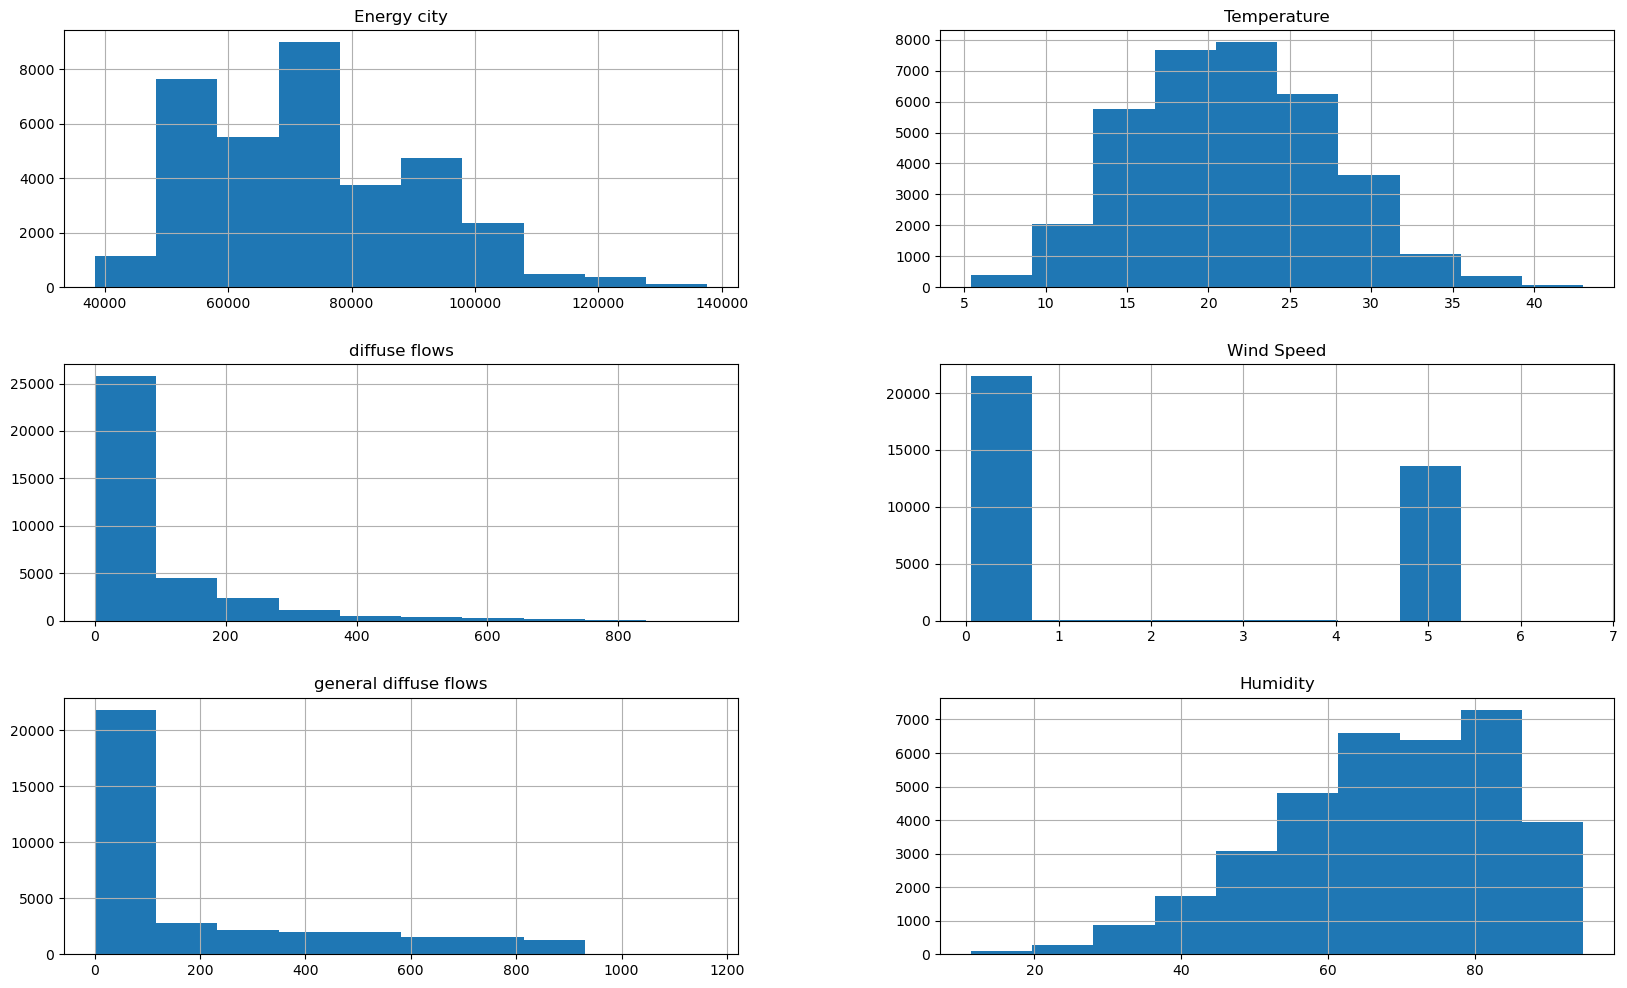

In [5]:
features = list(set(df_train.columns) - set(['DateTime']))

_ = df_train[features].hist(figsize=(20,12))

# УМЕНЬШАЕТ R2

<Axes: >

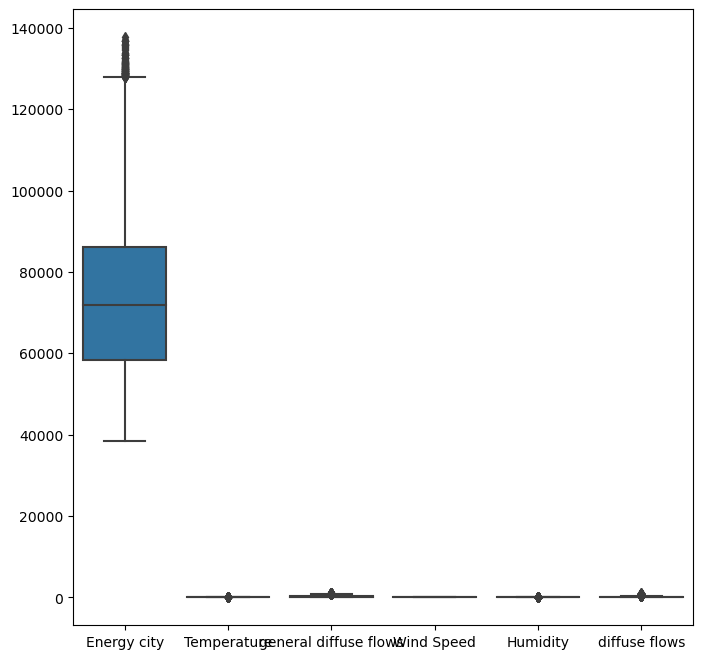

In [211]:
sns.boxplot(df_train[features])

In [212]:
def quantiles(arr):
    work_val = arr.copy()
    Q1 = work_val.quantile(0.25)#np.percentile(work_val, 25, method= 'midpoint')
    Q3 = work_val.quantile(0.75)#np.percentile(work_val, 75, method= 'midpoint')
    IQR = Q3-Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR
    return upper,lower

def anti_emmi(df):
    if df.select_dtypes(include = [np.number]).all().any():
        for col in df.select_dtypes(include = [np.number]).columns:
            
            up,low = quantiles(df[col])
            df = df[~(df[col] < low) & ~(df[col] > up)]

    return df.reset_index(drop=True)

In [213]:
df_train = anti_emmi(df_train)
df_train

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
0,12/31/2020/00:20,8.56239,74.5,0.08240,0.062,0.100,69837.318588
1,12/31/2020/00:30,8.36463,75.0,0.08549,0.091,0.096,67453.909053
2,12/31/2020/00:50,8.08859,76.9,0.08343,0.059,0.108,64036.484299
3,12/31/2020/01:20,7.90834,78.1,0.08343,0.066,0.141,59771.537889
4,12/31/2020/01:30,7.71573,77.3,0.08446,0.062,0.111,58723.307878
...,...,...,...,...,...,...,...
30218,12/29/2021/23:00,9.34210,72.5,0.08240,0.059,0.093,76651.906552
30219,12/29/2021/23:10,9.28030,72.4,0.08240,0.040,0.096,74982.029188
30220,12/29/2021/23:30,9.16700,72.8,0.08858,0.084,0.074,70735.301140
30221,12/29/2021/23:40,9.02074,73.0,0.08240,0.066,0.089,69177.907325


<Axes: >

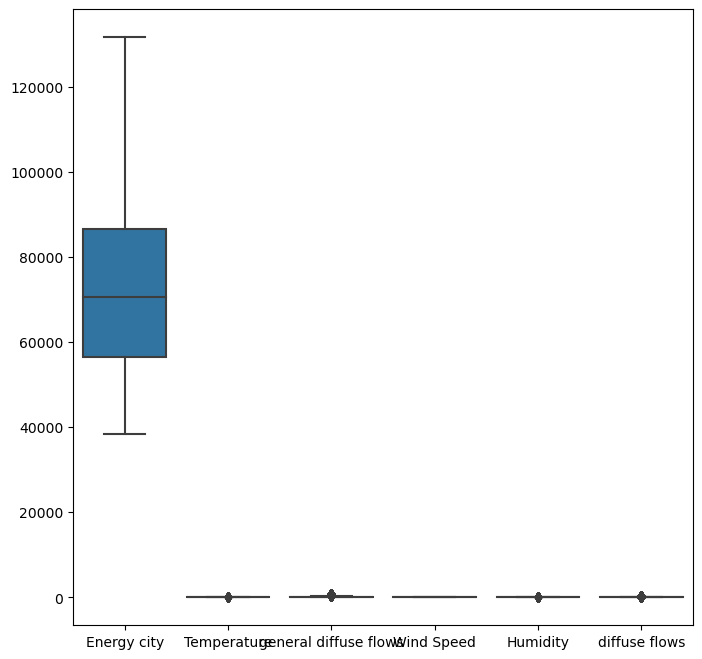

In [214]:
sns.boxplot(df_train[features])

# ___________________________________________________________

Посмотрим на то как значения корррелируют между собой, если какая-то пара значений имеет большой коэффициент то одно из них можно выкинуть

C:\Users\nicka\AppData\Local\Temp\ipykernel_12756\3996836933.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


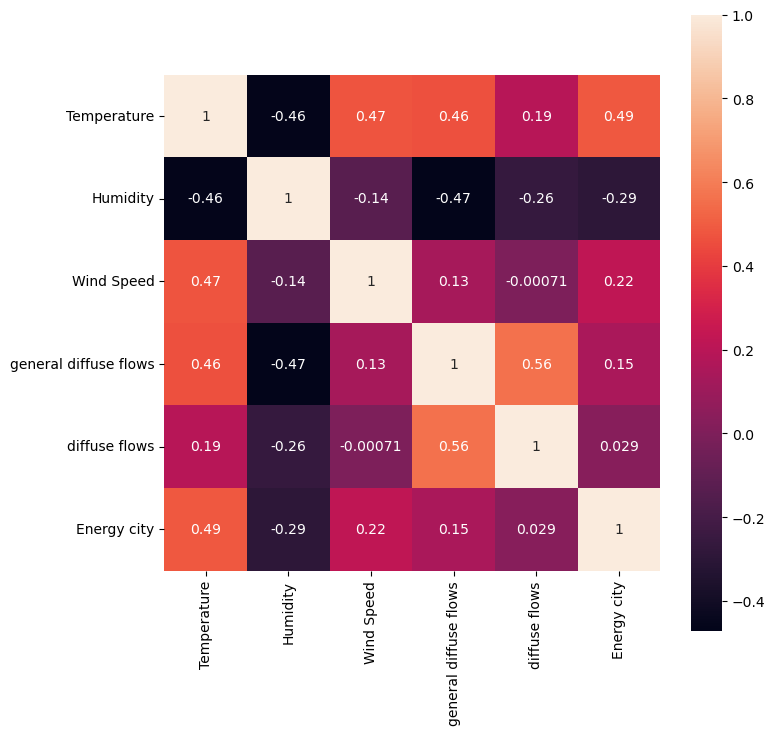

In [225]:
plt.rcParams['figure.figsize']=(8,8)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Предобработка данных

Стоить заметить что столбец **DateTime** имеет тип данных object, что говорит о некроореткном считывании типа данных, сменим тип его данных на data_time



In [30]:
df_train["DateTime"] = pd.to_datetime(df_train["DateTime"])

Большинство моделей плохо работают с временными рядами, по этому выделим из этого столбца самые главные показатели:

* Месяц
* Час

*Для повышения точности этот список можно расширить.* 

# ПОВЫШЕНИЕ ТОЧНОСТИ АААААААААААААААААААААААААААААААААААААААААААААААААА

In [31]:
df_train["Month"] = pd.to_datetime(df_train["DateTime"]).dt.month
df_train["Day"] = pd.to_datetime(df_train["DateTime"]).dt.day
df_train["Hour"] = pd.to_datetime(df_train["DateTime"]).dt.hour
df_train["Minute"] = pd.to_datetime(df_train["DateTime"]).dt.minute

In [113]:
(df_train['DateTime'].dt.day.isna()).sum()

0

In [114]:
df_train.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city,Month,Day,Hour,Minute
0,2020-12-31 00:20:00,8.56239,74.5,0.08240,0.062,0.100,69837.318588,12,31,0,20
1,2020-12-31 00:30:00,8.36463,75.0,0.08549,0.091,0.096,67453.909053,12,31,0,30
2,2020-12-31 00:50:00,8.08859,76.9,0.08343,0.059,0.108,64036.484299,12,31,0,50
3,2020-12-31 01:20:00,7.90834,78.1,0.08343,0.066,0.141,59771.537889,12,31,1,20
4,2020-12-31 01:30:00,7.71573,77.3,0.08446,0.062,0.111,58723.307878,12,31,1,30


Присутпим к созаднию собственной **обучающей** и **тестовой** выборки.

### Scalers

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [261]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [34]:
X = df_train.drop(["Energy city", "DateTime"], axis = 1)
y = df_train["Energy city"]
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [117]:
X

array([[-2.16355403,  0.40380722, -0.79999798, ...,  1.73790495,
        -1.66107035, -0.29063768],
       [-2.19674952,  0.43592139, -0.79872074, ...,  1.73790495,
        -1.66107035,  0.29527587],
       [-2.2430849 ,  0.55795526, -0.79957223, ...,  1.73790495,
        -1.66107035,  1.46710298],
       ...,
       [-2.06206572,  0.29461902, -0.7974435 , ...,  1.51023784,
         1.66344114,  0.29527587],
       [-2.08661656,  0.30746469, -0.79999798, ...,  1.51023784,
         1.66344114,  0.88118943],
       [-2.11739154,  0.37811588, -0.79957223, ...,  1.51023784,
         1.66344114,  1.46710298]])

### Normalizer

In [269]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X)  # fit does nothing.
transformer.transform(X)

array([[0.05070259, 0.45720087, 0.00281742, ..., 0.60414796, 0.        ,
        0.24165918],
       [0.04581802, 0.44424559, 0.00298769, ..., 0.58241812, 0.        ,
        0.34945087],
       [0.03748048, 0.41274003, 0.002532  , ..., 0.5254314 , 0.        ,
        0.5254314 ],
       ...,
       [0.05140693, 0.37859207, 0.00287704, ..., 0.47983742, 0.51411152,
        0.30846691],
       [0.04765974, 0.36637962, 0.00231267, ..., 0.46285285, 0.49591376,
        0.39673101],
       [0.04327306, 0.35667464, 0.00228568, ..., 0.44269483, 0.47431589,
        0.47431589]])

In [304]:
X = df_train.drop(["Energy city", "DateTime"], axis = 1)
y = df_train["Energy city"]
transformer.fit(X)
X = transformer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [64]:
X_train

array([[ 0.94800476,  1.58560887,  1.26316721, ..., -0.23502294,
         0.42821383, -0.36017455],
       [ 1.40962959, -1.27576416,  1.26146422, ...,  0.68977564,
         1.01028165,  0.50708932],
       [ 1.13300048, -0.35601418,  1.25933549, ..., -0.54240192,
        -0.15385399,  1.22980921],
       ...,
       [ 0.51404285, -1.52689701, -0.79914648, ...,  1.74636569,
        -0.73592182,  0.79617727],
       [-0.71868562,  0.68641196, -0.79914648, ..., -0.60277273,
        -1.60902355, -1.3719824 ],
       [ 0.06452055, -0.56090262, -0.80042372, ..., -0.60310342,
        -0.15385399, -0.93835046]])

## Выбор модели обучения

Многообразие выбора моделей линейной регресии, попробуй все варианты и узнай кто из них лучше всего справляется с этой задачей.

**Важно**: *не забывай что у каждой модели есть свои параметры которые стоить изменить.*

In [24]:
models = [LinearRegression(),        # метод наименьших квадратов
	          RandomForestRegressor(), # случайный лес
	          KNeighborsRegressor(),   # метод ближайших соседей
	          SVR(kernel='linear')]    # метод опорных векторов с линейным ядром

In [29]:
for model in models:
    print(f'{model}')
    new_mod = model.fit(X_train, y_train)
    y_prediction = new_mod.predict(X_test)
    print(r2_score(y_test, model.predict(X_test)))

LinearRegression()
0.6288522816755682
RandomForestRegressor()
0.9670386462645497
KNeighborsRegressor()
0.8504515000980266
SVR(kernel='linear')
0.6231502138288714


### StandartScaler

In [9]:
model_rand = RandomForestRegressor()
model_rand.fit(X_train, y_train)
print(r2_score(y_test, model_rand.predict(X_test)))


KeyboardInterrupt



# Grid

In [82]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators':[200],}
]
grid_search = GridSearchCV(model, param_grid, cv=3, scoring = 'neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train, y_train)
print('GridSearchCV Best Params:', grid_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..............min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END ..............min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END ..............min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END ..............min_samples_split=2, n_estimators=200; total time=  14.0s
[CV] END ..............min_samples_split=2, n_estimators=200; total time=  13.8s
[CV] END ..............min_samples_split=2, n_estimators=200; total time=  13.9s
[CV] END ..............min_samples_split=3, n_estimators=200; total time=  11.9s
[CV] END ..............min_samples_split=3, n_estimators=200; total time=  12.1s
[CV] END ..............min_samples_split=3, n_estimators=200; total time=  12.1s
[CV] END ..............min_samples_split=4, n_estimators=200; total time=  11.1s
[CV] END ..............min_samples_split=4, n_estimators=200; total time=  11.0s
[CV] END ..............min_samples_split=4, n_est

E:\hran\anacondaz\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "E:\hran\anacondaz\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\hran\anacondaz\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "E:\hran\anacondaz\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "E:\hran\anacondaz\Lib\site-packages\sklearn\utils\_param_validation.py", 

GridSearchCV Best Params: {'min_samples_split': 2, 'n_estimators': 200}


In [35]:
model = RandomForestRegressor(n_estimators = 300)
model.fit(X_train, y_train)
print(r2_score(y_test, model.predict(X_test)))

0.9826475011754126


In [ ]:
0.9841983807310515

In [191]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(loss_function='RMSE',verbose = 1,eval_metric='RMSE',task_type="GPU",
                           devices='0:1')

grid = {
        }

grid_search_result = model.grid_search(grid,
                                       X=X,
                                       y=y,
                                       train_size = 0.7,shuffle = True,plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 73235.6424816	test: 73031.3756135	best: 73031.3756135 (0)	total: 15.9ms	remaining: 15.9s
1:	learn: 71075.0490580	test: 70873.0804550	best: 70873.0804550 (1)	total: 31.6ms	remaining: 15.8s
2:	learn: 68981.6256414	test: 68784.0806685	best: 68784.0806685 (2)	total: 50.2ms	remaining: 16.7s
3:	learn: 66947.0573916	test: 66754.7839676	best: 66754.7839676 (3)	total: 66.9ms	remaining: 16.7s
4:	learn: 64977.1804302	test: 64788.9048949	best: 64788.9048949 (4)	total: 83ms	remaining: 16.5s
5:	learn: 63068.8257449	test: 62884.4462935	best: 62884.4462935 (5)	total: 102ms	remaining: 16.8s
6:	learn: 61221.1636070	test: 61039.3929236	best: 61039.3929236 (6)	total: 113ms	remaining: 16s
7:	learn: 59416.6153250	test: 59239.7653062	best: 59239.7653062 (7)	total: 128ms	remaining: 15.9s
8:	learn: 57689.4936567	test: 57514.1123604	best: 57514.1123604 (8)	total: 143ms	remaining: 15.7s
9:	learn: 56000.3959644	test: 55826.8393104	best: 55826.8393104 (9)	total: 158ms	remaining: 15.6s
10:	learn: 54362.46

83:	learn: 8371.4852243	test: 8371.8195150	best: 8371.8195150 (83)	total: 1.3s	remaining: 14.2s
84:	learn: 8229.5719634	test: 8231.9149076	best: 8231.9149076 (84)	total: 1.32s	remaining: 14.2s
85:	learn: 8096.6508617	test: 8100.4750523	best: 8100.4750523 (85)	total: 1.33s	remaining: 14.2s
86:	learn: 7970.0339503	test: 7975.7189606	best: 7975.7189606 (86)	total: 1.35s	remaining: 14.2s
87:	learn: 7849.8812666	test: 7857.8458475	best: 7857.8458475 (87)	total: 1.37s	remaining: 14.2s
88:	learn: 7726.6945302	test: 7735.9870691	best: 7735.9870691 (88)	total: 1.38s	remaining: 14.2s
89:	learn: 7605.7220474	test: 7616.0880019	best: 7616.0880019 (89)	total: 1.4s	remaining: 14.2s
90:	learn: 7499.3608681	test: 7511.8246713	best: 7511.8246713 (90)	total: 1.41s	remaining: 14.1s
91:	learn: 7397.2420642	test: 7412.3543882	best: 7412.3543882 (91)	total: 1.43s	remaining: 14.1s
92:	learn: 7296.7564464	test: 7313.2471418	best: 7313.2471418 (92)	total: 1.45s	remaining: 14.1s
93:	learn: 7198.0346386	test: 72

173:	learn: 4706.2969668	test: 4783.7474888	best: 4783.7474888 (173)	total: 2.8s	remaining: 13.3s
174:	learn: 4696.5322195	test: 4774.3764775	best: 4774.3764775 (174)	total: 2.82s	remaining: 13.3s
175:	learn: 4690.1236915	test: 4768.0147579	best: 4768.0147579 (175)	total: 2.84s	remaining: 13.3s
176:	learn: 4677.1481962	test: 4755.5592744	best: 4755.5592744 (176)	total: 2.86s	remaining: 13.3s
177:	learn: 4670.7224902	test: 4749.2687774	best: 4749.2687774 (177)	total: 2.88s	remaining: 13.3s
178:	learn: 4665.1799408	test: 4744.0302951	best: 4744.0302951 (178)	total: 2.9s	remaining: 13.3s
179:	learn: 4656.7975002	test: 4736.1200092	best: 4736.1200092 (179)	total: 2.91s	remaining: 13.3s
180:	learn: 4648.2723304	test: 4728.0361534	best: 4728.0361534 (180)	total: 2.93s	remaining: 13.2s
181:	learn: 4638.4960735	test: 4718.1736786	best: 4718.1736786 (181)	total: 2.94s	remaining: 13.2s
182:	learn: 4631.4388472	test: 4710.8508318	best: 4710.8508318 (182)	total: 2.96s	remaining: 13.2s
183:	learn: 

262:	learn: 4213.5820225	test: 4308.2718044	best: 4308.2718044 (262)	total: 4.35s	remaining: 12.2s
263:	learn: 4209.9108079	test: 4304.6991328	best: 4304.6991328 (263)	total: 4.37s	remaining: 12.2s
264:	learn: 4205.7524362	test: 4300.0640365	best: 4300.0640365 (264)	total: 4.39s	remaining: 12.2s
265:	learn: 4203.3002814	test: 4297.8640158	best: 4297.8640158 (265)	total: 4.41s	remaining: 12.2s
266:	learn: 4199.6192851	test: 4294.4753293	best: 4294.4753293 (266)	total: 4.42s	remaining: 12.1s
267:	learn: 4196.6512313	test: 4291.3847406	best: 4291.3847406 (267)	total: 4.44s	remaining: 12.1s
268:	learn: 4192.7914484	test: 4287.6059611	best: 4287.6059611 (268)	total: 4.46s	remaining: 12.1s
269:	learn: 4190.9550091	test: 4286.1576976	best: 4286.1576976 (269)	total: 4.48s	remaining: 12.1s
270:	learn: 4185.6985047	test: 4281.0483207	best: 4281.0483207 (270)	total: 4.5s	remaining: 12.1s
271:	learn: 4181.8805704	test: 4277.2604095	best: 4277.2604095 (271)	total: 4.51s	remaining: 12.1s
272:	learn:

360:	learn: 4001.1426099	test: 4104.3169169	best: 4104.3169169 (360)	total: 5.86s	remaining: 10.4s
361:	learn: 4001.1419436	test: 4104.3167275	best: 4104.3167275 (361)	total: 5.87s	remaining: 10.3s
362:	learn: 3999.1910011	test: 4102.0871625	best: 4102.0871625 (362)	total: 5.88s	remaining: 10.3s
363:	learn: 3999.1866679	test: 4102.0820448	best: 4102.0820448 (363)	total: 5.89s	remaining: 10.3s
364:	learn: 3996.7950503	test: 4099.8068869	best: 4099.8068869 (364)	total: 5.91s	remaining: 10.3s
365:	learn: 3991.9606005	test: 4094.9279159	best: 4094.9279159 (365)	total: 5.93s	remaining: 10.3s
366:	learn: 3986.5727885	test: 4089.3927347	best: 4089.3927347 (366)	total: 5.94s	remaining: 10.3s
367:	learn: 3984.5611861	test: 4087.8188989	best: 4087.8188989 (367)	total: 5.96s	remaining: 10.2s
368:	learn: 3981.8670352	test: 4085.2428981	best: 4085.2428981 (368)	total: 5.97s	remaining: 10.2s
369:	learn: 3979.5114019	test: 4083.0309108	best: 4083.0309108 (369)	total: 5.99s	remaining: 10.2s
370:	learn

454:	learn: 3799.7467125	test: 3908.4383698	best: 3908.4383698 (454)	total: 7.37s	remaining: 8.82s
455:	learn: 3798.7160539	test: 3907.5275398	best: 3907.5275398 (455)	total: 7.38s	remaining: 8.81s
456:	learn: 3797.2693269	test: 3905.9228246	best: 3905.9228246 (456)	total: 7.41s	remaining: 8.8s
457:	learn: 3795.4046509	test: 3904.1117277	best: 3904.1117277 (457)	total: 7.42s	remaining: 8.78s
458:	learn: 3793.8368488	test: 3902.4982361	best: 3902.4982361 (458)	total: 7.44s	remaining: 8.77s
459:	learn: 3790.8714293	test: 3899.6835866	best: 3899.6835866 (459)	total: 7.46s	remaining: 8.76s
460:	learn: 3789.3835401	test: 3898.1568232	best: 3898.1568232 (460)	total: 7.47s	remaining: 8.74s
461:	learn: 3786.2465251	test: 3894.8471818	best: 3894.8471818 (461)	total: 7.49s	remaining: 8.72s
462:	learn: 3784.9848632	test: 3893.4954585	best: 3893.4954585 (462)	total: 7.51s	remaining: 8.71s
463:	learn: 3784.9813413	test: 3893.4932618	best: 3893.4932618 (463)	total: 7.52s	remaining: 8.69s
464:	learn:

550:	learn: 3662.3062134	test: 3772.5477443	best: 3772.5477443 (550)	total: 8.87s	remaining: 7.23s
551:	learn: 3660.4565436	test: 3770.7913576	best: 3770.7913576 (551)	total: 8.89s	remaining: 7.21s
552:	learn: 3656.8167317	test: 3767.0771632	best: 3767.0771632 (552)	total: 8.9s	remaining: 7.2s
553:	learn: 3655.3238718	test: 3765.5387564	best: 3765.5387564 (553)	total: 8.92s	remaining: 7.18s
554:	learn: 3653.3555516	test: 3763.7105135	best: 3763.7105135 (554)	total: 8.94s	remaining: 7.17s
555:	learn: 3650.9971687	test: 3761.0624067	best: 3761.0624067 (555)	total: 8.96s	remaining: 7.15s
556:	learn: 3650.5843909	test: 3760.6249404	best: 3760.6249404 (556)	total: 8.97s	remaining: 7.13s
557:	learn: 3648.7201935	test: 3758.7885155	best: 3758.7885155 (557)	total: 8.99s	remaining: 7.12s
558:	learn: 3646.9619569	test: 3757.3537013	best: 3757.3537013 (558)	total: 9.01s	remaining: 7.11s
559:	learn: 3645.8625143	test: 3756.4126540	best: 3756.4126540 (559)	total: 9.02s	remaining: 7.09s
560:	learn: 

650:	learn: 3562.2007289	test: 3674.1504994	best: 3674.1504994 (649)	total: 10.3s	remaining: 5.54s
651:	learn: 3562.2009160	test: 3674.1500762	best: 3674.1500762 (651)	total: 10.4s	remaining: 5.53s
652:	learn: 3562.0545972	test: 3673.9900877	best: 3673.9900877 (652)	total: 10.4s	remaining: 5.51s
653:	learn: 3562.0544101	test: 3673.9900877	best: 3673.9900877 (652)	total: 10.4s	remaining: 5.49s
654:	learn: 3559.9315506	test: 3672.0161124	best: 3672.0161124 (654)	total: 10.4s	remaining: 5.48s
655:	learn: 3559.9309889	test: 3672.0154771	best: 3672.0154771 (655)	total: 10.4s	remaining: 5.46s
656:	learn: 3559.9309889	test: 3672.0146302	best: 3672.0146302 (656)	total: 10.4s	remaining: 5.44s
657:	learn: 3559.9311762	test: 3672.0139949	best: 3672.0139949 (657)	total: 10.4s	remaining: 5.42s
658:	learn: 3558.0953476	test: 3670.2899991	best: 3670.2899991 (658)	total: 10.4s	remaining: 5.41s
659:	learn: 3556.0793960	test: 3668.2743965	best: 3668.2743965 (659)	total: 10.5s	remaining: 5.39s
660:	learn

737:	learn: 3513.8400995	test: 3626.6176423	best: 3626.6176423 (737)	total: 11.4s	remaining: 4.06s
738:	learn: 3513.8400995	test: 3626.6178567	best: 3626.6176423 (737)	total: 11.4s	remaining: 4.04s
739:	learn: 3513.0088249	test: 3625.7338029	best: 3625.7338029 (739)	total: 11.5s	remaining: 4.03s
740:	learn: 3512.9997182	test: 3625.7374485	best: 3625.7338029 (739)	total: 11.5s	remaining: 4.01s
741:	learn: 3512.9926983	test: 3625.7342318	best: 3625.7338029 (739)	total: 11.5s	remaining: 3.99s
742:	learn: 3511.5411889	test: 3624.5582330	best: 3624.5582330 (742)	total: 11.5s	remaining: 3.98s
743:	learn: 3509.2768584	test: 3622.2857993	best: 3622.2857993 (743)	total: 11.5s	remaining: 3.96s
744:	learn: 3509.2770483	test: 3622.2857993	best: 3622.2857993 (743)	total: 11.5s	remaining: 3.94s
745:	learn: 3509.2770483	test: 3622.2853700	best: 3622.2853700 (745)	total: 11.5s	remaining: 3.92s
746:	learn: 3509.2770483	test: 3622.2851553	best: 3622.2851553 (746)	total: 11.5s	remaining: 3.91s
747:	learn

823:	learn: 3477.1973561	test: 3591.2710711	best: 3591.2708546 (821)	total: 12.5s	remaining: 2.67s
824:	learn: 3477.1940975	test: 3591.2693390	best: 3591.2693390 (824)	total: 12.5s	remaining: 2.65s
825:	learn: 3477.1939059	test: 3591.2694473	best: 3591.2693390 (824)	total: 12.5s	remaining: 2.64s
826:	learn: 3475.5239835	test: 3589.8207424	best: 3589.8207424 (826)	total: 12.5s	remaining: 2.62s
827:	learn: 3475.5237918	test: 3589.8206341	best: 3589.8206341 (827)	total: 12.5s	remaining: 2.61s
828:	learn: 3475.5237918	test: 3589.8206341	best: 3589.8206341 (827)	total: 12.6s	remaining: 2.59s
829:	learn: 3475.5207234	test: 3589.8192263	best: 3589.8192263 (829)	total: 12.6s	remaining: 2.57s
830:	learn: 3475.5180386	test: 3589.8177101	best: 3589.8177101 (830)	total: 12.6s	remaining: 2.56s
831:	learn: 3475.2756315	test: 3589.5481517	best: 3589.5481517 (831)	total: 12.6s	remaining: 2.54s
832:	learn: 3475.2727547	test: 3589.5467437	best: 3589.5467437 (832)	total: 12.6s	remaining: 2.53s
833:	learn

919:	learn: 3445.0576825	test: 3560.7423044	best: 3560.7423044 (919)	total: 13.8s	remaining: 1.2s
920:	learn: 3445.0559413	test: 3560.7409943	best: 3560.7409943 (920)	total: 13.8s	remaining: 1.18s
921:	learn: 3445.0565217	test: 3560.7413218	best: 3560.7409943 (920)	total: 13.8s	remaining: 1.17s
922:	learn: 3445.0547805	test: 3560.7439421	best: 3560.7409943 (920)	total: 13.8s	remaining: 1.15s
923:	learn: 3444.3779669	test: 3560.2230058	best: 3560.2230058 (923)	total: 13.8s	remaining: 1.14s
924:	learn: 3444.3766124	test: 3560.2212587	best: 3560.2212587 (924)	total: 13.9s	remaining: 1.12s
925:	learn: 3442.9389576	test: 3558.8366010	best: 3558.8366010 (925)	total: 13.9s	remaining: 1.11s
926:	learn: 3441.8971150	test: 3557.7839314	best: 3557.7839314 (926)	total: 13.9s	remaining: 1.09s
927:	learn: 3441.8961468	test: 3557.7794513	best: 3557.7794513 (927)	total: 13.9s	remaining: 1.08s
928:	learn: 3441.8961468	test: 3557.7795606	best: 3557.7794513 (927)	total: 13.9s	remaining: 1.06s
929:	learn:

3:	learn: 66838.2946623	test: 67014.8244232	best: 67014.8244232 (3)	total: 68.7ms	remaining: 17.1s
4:	learn: 64872.0220683	test: 65046.7629822	best: 65046.7629822 (4)	total: 87.1ms	remaining: 17.3s
5:	learn: 62965.3493679	test: 63138.1572298	best: 63138.1572298 (5)	total: 105ms	remaining: 17.3s
6:	learn: 61121.5035412	test: 61291.9104178	best: 61291.9104178 (6)	total: 115ms	remaining: 16.3s
7:	learn: 59319.8725443	test: 59487.7668784	best: 59487.7668784 (7)	total: 129ms	remaining: 16s
8:	learn: 57595.7919347	test: 57760.6769742	best: 57760.6769742 (8)	total: 142ms	remaining: 15.7s
9:	learn: 55910.1284697	test: 56072.2831937	best: 56072.2831937 (9)	total: 158ms	remaining: 15.6s
10:	learn: 54269.2353418	test: 54427.7323236	best: 54427.7323236 (10)	total: 172ms	remaining: 15.5s
11:	learn: 52683.8309784	test: 52841.0908852	best: 52841.0908852 (11)	total: 187ms	remaining: 15.4s
12:	learn: 51147.0143054	test: 51301.7722431	best: 51301.7722431 (12)	total: 203ms	remaining: 15.4s
13:	learn: 496

86:	learn: 7916.7038438	test: 7989.9826981	best: 7989.9826981 (86)	total: 1.36s	remaining: 14.3s
87:	learn: 7791.6443014	test: 7864.4390298	best: 7864.4390298 (87)	total: 1.39s	remaining: 14.4s
88:	learn: 7669.4441724	test: 7741.9940611	best: 7741.9940611 (88)	total: 1.4s	remaining: 14.4s
89:	learn: 7558.4295663	test: 7630.1167160	best: 7630.1167160 (89)	total: 1.42s	remaining: 14.3s
90:	learn: 7449.2299216	test: 7520.0805315	best: 7520.0805315 (90)	total: 1.44s	remaining: 14.4s
91:	learn: 7345.6239813	test: 7416.1444503	best: 7416.1444503 (91)	total: 1.45s	remaining: 14.4s
92:	learn: 7246.7573934	test: 7316.7322105	best: 7316.7322105 (92)	total: 1.47s	remaining: 14.3s
93:	learn: 7152.1132189	test: 7221.7228687	best: 7221.7228687 (93)	total: 1.48s	remaining: 14.3s
94:	learn: 7062.5560651	test: 7132.6343396	best: 7132.6343396 (94)	total: 1.5s	remaining: 14.3s
95:	learn: 6975.1020540	test: 7043.8858667	best: 7043.8858667 (95)	total: 1.51s	remaining: 14.2s
96:	learn: 6882.2380556	test: 69

181:	learn: 4634.1976411	test: 4696.3522900	best: 4696.3522900 (181)	total: 2.89s	remaining: 13s
182:	learn: 4627.0525119	test: 4689.3349976	best: 4689.3349976 (182)	total: 2.91s	remaining: 13s
183:	learn: 4619.9897929	test: 4682.6226854	best: 4682.6226854 (183)	total: 2.93s	remaining: 13s
184:	learn: 4610.7612131	test: 4673.5679480	best: 4673.5679480 (184)	total: 2.94s	remaining: 13s
185:	learn: 4602.8674645	test: 4666.0486308	best: 4666.0486308 (185)	total: 2.96s	remaining: 13s
186:	learn: 4596.3988596	test: 4659.4454565	best: 4659.4454565 (186)	total: 2.98s	remaining: 12.9s
187:	learn: 4588.6463363	test: 4651.5532348	best: 4651.5532348 (187)	total: 2.99s	remaining: 12.9s
188:	learn: 4583.8423657	test: 4647.0475732	best: 4647.0475732 (188)	total: 3.01s	remaining: 12.9s
189:	learn: 4577.9915497	test: 4641.4225383	best: 4641.4225383 (189)	total: 3.02s	remaining: 12.9s
190:	learn: 4570.8916060	test: 4634.2355445	best: 4634.2355445 (190)	total: 3.04s	remaining: 12.9s
191:	learn: 4564.066

271:	learn: 4205.8156126	test: 4276.4513399	best: 4276.4513399 (271)	total: 4.41s	remaining: 11.8s
272:	learn: 4202.5355886	test: 4273.7883636	best: 4273.7883636 (272)	total: 4.43s	remaining: 11.8s
273:	learn: 4195.2903253	test: 4266.0822836	best: 4266.0822836 (273)	total: 4.45s	remaining: 11.8s
274:	learn: 4195.2786487	test: 4266.0522640	best: 4266.0522640 (274)	total: 4.46s	remaining: 11.8s
275:	learn: 4194.1365158	test: 4264.9507433	best: 4264.9507433 (275)	total: 4.48s	remaining: 11.7s
276:	learn: 4194.1265045	test: 4264.9246538	best: 4264.9246538 (276)	total: 4.49s	remaining: 11.7s
277:	learn: 4194.1174943	test: 4264.8995486	best: 4264.8995486 (277)	total: 4.5s	remaining: 11.7s
278:	learn: 4194.0978053	test: 4264.8806787	best: 4264.8806787 (278)	total: 4.52s	remaining: 11.7s
279:	learn: 4191.2696369	test: 4262.0817464	best: 4262.0817464 (279)	total: 4.54s	remaining: 11.7s
280:	learn: 4191.2614554	test: 4262.0569528	best: 4262.0569528 (280)	total: 4.55s	remaining: 11.6s
281:	learn:

356:	learn: 4132.4169594	test: 4204.5396952	best: 4204.5396952 (356)	total: 5.52s	remaining: 9.94s
357:	learn: 4132.4166207	test: 4204.5400281	best: 4204.5396952 (356)	total: 5.53s	remaining: 9.91s
358:	learn: 4132.4169594	test: 4204.5400281	best: 4204.5396952 (356)	total: 5.54s	remaining: 9.89s
359:	learn: 4132.4166207	test: 4204.5405275	best: 4204.5396952 (356)	total: 5.55s	remaining: 9.86s
360:	learn: 4132.4162820	test: 4204.5408603	best: 4204.5396952 (356)	total: 5.56s	remaining: 9.84s
361:	learn: 4132.4162820	test: 4204.5408603	best: 4204.5396952 (356)	total: 5.57s	remaining: 9.81s
362:	learn: 4132.4162820	test: 4204.5411932	best: 4204.5396952 (356)	total: 5.58s	remaining: 9.78s
363:	learn: 4132.4132338	test: 4204.5265463	best: 4204.5265463 (363)	total: 5.59s	remaining: 9.76s
364:	learn: 4132.4100162	test: 4204.5127315	best: 4204.5127315 (364)	total: 5.6s	remaining: 9.74s
365:	learn: 4132.4098468	test: 4204.5125651	best: 4204.5125651 (365)	total: 5.61s	remaining: 9.72s
366:	learn:

440:	learn: 3957.7477714	test: 4039.6229497	best: 4039.6229497 (440)	total: 7.01s	remaining: 8.88s
441:	learn: 3954.4791272	test: 4035.9209116	best: 4035.9209116 (441)	total: 7.03s	remaining: 8.87s
442:	learn: 3950.7097046	test: 4032.0290719	best: 4032.0290719 (442)	total: 7.04s	remaining: 8.86s
443:	learn: 3949.6821834	test: 4031.0901590	best: 4031.0901590 (443)	total: 7.06s	remaining: 8.84s
444:	learn: 3946.2077134	test: 4027.4190265	best: 4027.4190265 (444)	total: 7.08s	remaining: 8.82s
445:	learn: 3943.0704234	test: 4024.5975347	best: 4024.5975347 (445)	total: 7.09s	remaining: 8.81s
446:	learn: 3940.7547078	test: 4022.3633780	best: 4022.3633780 (446)	total: 7.11s	remaining: 8.79s
447:	learn: 3938.5934597	test: 4020.1633171	best: 4020.1633171 (447)	total: 7.12s	remaining: 8.78s
448:	learn: 3934.6681360	test: 4016.7050378	best: 4016.7050378 (448)	total: 7.14s	remaining: 8.76s
449:	learn: 3931.7615747	test: 4013.8625899	best: 4013.8625899 (449)	total: 7.16s	remaining: 8.75s
450:	learn

528:	learn: 3811.2865544	test: 3899.8617633	best: 3899.8617633 (528)	total: 8.31s	remaining: 7.4s
529:	learn: 3811.2865544	test: 3899.8608661	best: 3899.8608661 (529)	total: 8.32s	remaining: 7.38s
530:	learn: 3811.2869217	test: 3899.8605072	best: 3899.8605072 (530)	total: 8.33s	remaining: 7.36s
531:	learn: 3809.0479888	test: 3897.4995471	best: 3897.4995471 (531)	total: 8.35s	remaining: 7.34s
532:	learn: 3809.0478051	test: 3897.4988288	best: 3897.4988288 (532)	total: 8.36s	remaining: 7.33s
533:	learn: 3809.0478051	test: 3897.4984697	best: 3897.4984697 (533)	total: 8.37s	remaining: 7.3s
534:	learn: 3809.0468865	test: 3897.4921853	best: 3897.4921853 (534)	total: 8.38s	remaining: 7.29s
535:	learn: 3809.0472539	test: 3897.4914671	best: 3897.4914671 (535)	total: 8.39s	remaining: 7.27s
536:	learn: 3809.0468865	test: 3897.4909284	best: 3897.4909284 (536)	total: 8.4s	remaining: 7.25s
537:	learn: 3809.0470702	test: 3897.4907489	best: 3897.4907489 (537)	total: 8.41s	remaining: 7.22s
538:	learn: 3

614:	learn: 3797.7668210	test: 3887.0842406	best: 3887.0842406 (614)	total: 9.17s	remaining: 5.74s
615:	learn: 3797.7668210	test: 3887.0840605	best: 3887.0840605 (615)	total: 9.18s	remaining: 5.72s
616:	learn: 3797.7651626	test: 3887.0782994	best: 3887.0782994 (616)	total: 9.19s	remaining: 5.71s
617:	learn: 3797.7638727	test: 3887.0725383	best: 3887.0725383 (617)	total: 9.21s	remaining: 5.69s
618:	learn: 3797.7638727	test: 3887.0723582	best: 3887.0723582 (618)	total: 9.21s	remaining: 5.67s
619:	learn: 3797.7636885	test: 3887.0721782	best: 3887.0721782 (619)	total: 9.22s	remaining: 5.65s
620:	learn: 3797.7629514	test: 3887.0719982	best: 3887.0719982 (620)	total: 9.23s	remaining: 5.63s
621:	learn: 3797.7629514	test: 3887.0703778	best: 3887.0703778 (621)	total: 9.24s	remaining: 5.62s
622:	learn: 3797.7616615	test: 3887.0646167	best: 3887.0646167 (622)	total: 9.25s	remaining: 5.6s
623:	learn: 3797.7600031	test: 3887.0597557	best: 3887.0597557 (623)	total: 9.26s	remaining: 5.58s
624:	learn:

712:	learn: 3762.3180353	test: 3852.7663861	best: 3852.7663861 (712)	total: 10.2s	remaining: 4.12s
713:	learn: 3762.3182213	test: 3852.7662044	best: 3852.7662044 (713)	total: 10.2s	remaining: 4.1s
714:	learn: 3762.3182213	test: 3852.7660228	best: 3852.7660228 (714)	total: 10.2s	remaining: 4.08s
715:	learn: 3762.3184073	test: 3852.7651146	best: 3852.7651146 (715)	total: 10.3s	remaining: 4.07s
716:	learn: 3762.3184073	test: 3852.7649329	best: 3852.7649329 (716)	total: 10.3s	remaining: 4.05s
717:	learn: 3762.3185933	test: 3852.7649329	best: 3852.7649329 (716)	total: 10.3s	remaining: 4.04s
718:	learn: 3762.3184073	test: 3852.7638431	best: 3852.7638431 (718)	total: 10.3s	remaining: 4.02s
719:	learn: 3762.3187793	test: 3852.7629349	best: 3852.7629349 (719)	total: 10.3s	remaining: 4s
720:	learn: 3762.3187793	test: 3852.7623900	best: 3852.7623900 (720)	total: 10.3s	remaining: 3.99s
721:	learn: 3762.3184073	test: 3852.7616634	best: 3852.7616634 (721)	total: 10.3s	remaining: 3.97s
722:	learn: 37

797:	learn: 3694.5814711	test: 3789.0083494	best: 3789.0083494 (797)	total: 11.3s	remaining: 2.86s
798:	learn: 3693.4556015	test: 3788.0893788	best: 3788.0893788 (798)	total: 11.3s	remaining: 2.85s
799:	learn: 3693.4556015	test: 3788.0893788	best: 3788.0893788 (798)	total: 11.3s	remaining: 2.83s
800:	learn: 3693.4557910	test: 3788.0893788	best: 3788.0893788 (798)	total: 11.3s	remaining: 2.82s
801:	learn: 3691.3397130	test: 3786.2289585	best: 3786.2289585 (801)	total: 11.4s	remaining: 2.81s
802:	learn: 3691.3395234	test: 3786.2285889	best: 3786.2285889 (802)	total: 11.4s	remaining: 2.79s
803:	learn: 3689.9778829	test: 3785.0146097	best: 3785.0146097 (803)	total: 11.4s	remaining: 2.78s
804:	learn: 3687.3588062	test: 3782.8566958	best: 3782.8566958 (804)	total: 11.4s	remaining: 2.76s
805:	learn: 3687.3584266	test: 3782.8561408	best: 3782.8561408 (805)	total: 11.4s	remaining: 2.75s
806:	learn: 3687.3584266	test: 3782.8557708	best: 3782.8557708 (806)	total: 11.4s	remaining: 2.73s
807:	learn

881:	learn: 3593.7238425	test: 3693.6602273	best: 3693.6602273 (881)	total: 12.6s	remaining: 1.68s
882:	learn: 3592.2172768	test: 3692.4889706	best: 3692.4889706 (882)	total: 12.6s	remaining: 1.67s
883:	learn: 3592.2170820	test: 3692.4887811	best: 3692.4887811 (883)	total: 12.6s	remaining: 1.66s
884:	learn: 3590.1709584	test: 3690.9125597	best: 3690.9125597 (884)	total: 12.6s	remaining: 1.64s
885:	learn: 3588.3908570	test: 3689.3916217	best: 3689.3916217 (885)	total: 12.6s	remaining: 1.63s
886:	learn: 3588.3908570	test: 3689.3914320	best: 3689.3914320 (886)	total: 12.7s	remaining: 1.61s
887:	learn: 3586.3351354	test: 3687.6045719	best: 3687.6045719 (887)	total: 12.7s	remaining: 1.6s
888:	learn: 3585.1618043	test: 3686.4249368	best: 3686.4249368 (888)	total: 12.7s	remaining: 1.58s
889:	learn: 3582.2633268	test: 3683.9137049	best: 3683.9137049 (889)	total: 12.7s	remaining: 1.57s
890:	learn: 3582.2631314	test: 3683.9137049	best: 3683.9137049 (889)	total: 12.7s	remaining: 1.55s
891:	learn:

974:	learn: 3475.2191334	test: 3590.0998103	best: 3590.0998103 (974)	total: 14.1s	remaining: 361ms
975:	learn: 3473.7802335	test: 3588.9598835	best: 3588.9598835 (975)	total: 14.1s	remaining: 346ms
976:	learn: 3473.7776146	test: 3588.9596885	best: 3588.9596885 (976)	total: 14.1s	remaining: 332ms
977:	learn: 3473.2727301	test: 3588.4969469	best: 3588.4969469 (977)	total: 14.1s	remaining: 317ms
978:	learn: 3471.5606938	test: 3586.9973554	best: 3586.9973554 (978)	total: 14.1s	remaining: 303ms
979:	learn: 3468.1508337	test: 3583.9203330	best: 3583.9203330 (979)	total: 14.1s	remaining: 288ms
980:	learn: 3467.2172623	test: 3582.9499328	best: 3582.9499328 (980)	total: 14.1s	remaining: 274ms
981:	learn: 3466.7013291	test: 3582.4905171	best: 3582.4905171 (981)	total: 14.2s	remaining: 260ms
982:	learn: 3466.6997141	test: 3582.4907124	best: 3582.4905171 (981)	total: 14.2s	remaining: 245ms
983:	learn: 3466.6997141	test: 3582.4901264	best: 3582.4901264 (983)	total: 14.2s	remaining: 231ms
984:	learn

58:	learn: 14270.5564420	test: 14282.6062876	best: 14282.6062876 (58)	total: 925ms	remaining: 14.7s
59:	learn: 13927.6187967	test: 13939.7369651	best: 13939.7369651 (59)	total: 940ms	remaining: 14.7s
60:	learn: 13590.6622470	test: 13602.6731416	best: 13602.6731416 (60)	total: 958ms	remaining: 14.8s
61:	learn: 13263.5414972	test: 13276.1017895	best: 13276.1017895 (61)	total: 978ms	remaining: 14.8s
62:	learn: 12955.1817069	test: 12966.7368223	best: 12966.7368223 (62)	total: 994ms	remaining: 14.8s
63:	learn: 12648.6973423	test: 12660.1112033	best: 12660.1112033 (63)	total: 1.01s	remaining: 14.8s
64:	learn: 12357.0015502	test: 12367.7385491	best: 12367.7385491 (64)	total: 1.03s	remaining: 14.8s
65:	learn: 12076.3739220	test: 12086.6895123	best: 12086.6895123 (65)	total: 1.04s	remaining: 14.8s
66:	learn: 11803.2914724	test: 11813.8151854	best: 11813.8151854 (66)	total: 1.06s	remaining: 14.8s
67:	learn: 11539.1957920	test: 11550.2815025	best: 11550.2815025 (67)	total: 1.08s	remaining: 14.8s


154:	learn: 4917.1417316	test: 4908.3395599	best: 4908.3395599 (154)	total: 2.45s	remaining: 13.3s
155:	learn: 4906.2301205	test: 4897.2014218	best: 4897.2014218 (155)	total: 2.46s	remaining: 13.3s
156:	learn: 4896.2024460	test: 4886.9931234	best: 4886.9931234 (156)	total: 2.48s	remaining: 13.3s
157:	learn: 4886.5271320	test: 4877.1770040	best: 4877.1770040 (157)	total: 2.49s	remaining: 13.3s
158:	learn: 4873.4753535	test: 4865.1246912	best: 4865.1246912 (158)	total: 2.51s	remaining: 13.3s
159:	learn: 4864.7403287	test: 4856.3100883	best: 4856.3100883 (159)	total: 2.53s	remaining: 13.3s
160:	learn: 4854.7837907	test: 4846.6437936	best: 4846.6437936 (160)	total: 2.54s	remaining: 13.2s
161:	learn: 4845.7120929	test: 4837.1966087	best: 4837.1966087 (161)	total: 2.56s	remaining: 13.2s
162:	learn: 4837.6274259	test: 4829.3972169	best: 4829.3972169 (162)	total: 2.57s	remaining: 13.2s
163:	learn: 4827.9732985	test: 4819.0574877	best: 4819.0574877 (163)	total: 2.59s	remaining: 13.2s
164:	learn

250:	learn: 4244.1040610	test: 4242.9989865	best: 4242.9989865 (250)	total: 3.96s	remaining: 11.8s
251:	learn: 4239.5854721	test: 4238.0824434	best: 4238.0824434 (251)	total: 3.98s	remaining: 11.8s
252:	learn: 4236.0758685	test: 4234.9597758	best: 4234.9597758 (252)	total: 4s	remaining: 11.8s
253:	learn: 4232.3844531	test: 4231.6085739	best: 4231.6085739 (253)	total: 4.01s	remaining: 11.8s
254:	learn: 4228.8172418	test: 4227.9586108	best: 4227.9586108 (254)	total: 4.02s	remaining: 11.8s
255:	learn: 4224.3908097	test: 4223.6641630	best: 4223.6641630 (255)	total: 4.04s	remaining: 11.7s
256:	learn: 4221.1376537	test: 4220.9100213	best: 4220.9100213 (256)	total: 4.05s	remaining: 11.7s
257:	learn: 4216.8903610	test: 4216.7912849	best: 4216.7912849 (257)	total: 4.07s	remaining: 11.7s
258:	learn: 4213.7680982	test: 4214.0922690	best: 4214.0922690 (258)	total: 4.09s	remaining: 11.7s
259:	learn: 4210.3235717	test: 4211.0855910	best: 4211.0855910 (259)	total: 4.11s	remaining: 11.7s
260:	learn: 4

346:	learn: 3984.8152387	test: 3993.9599762	best: 3993.9599762 (346)	total: 5.44s	remaining: 10.2s
347:	learn: 3982.1763814	test: 3991.3122616	best: 3991.3122616 (347)	total: 5.46s	remaining: 10.2s
348:	learn: 3978.1941438	test: 3987.1057150	best: 3987.1057150 (348)	total: 5.47s	remaining: 10.2s
349:	learn: 3975.2342029	test: 3984.1028615	best: 3984.1028615 (349)	total: 5.49s	remaining: 10.2s
350:	learn: 3972.8965451	test: 3981.5512391	best: 3981.5512391 (350)	total: 5.51s	remaining: 10.2s
351:	learn: 3969.9749609	test: 3979.0514465	best: 3979.0514465 (351)	total: 5.52s	remaining: 10.2s
352:	learn: 3967.3959076	test: 3976.4251313	best: 3976.4251313 (352)	total: 5.54s	remaining: 10.2s
353:	learn: 3965.6866655	test: 3975.2134298	best: 3975.2134298 (353)	total: 5.55s	remaining: 10.1s
354:	learn: 3965.6852538	test: 3975.2044515	best: 3975.2044515 (354)	total: 5.57s	remaining: 10.1s
355:	learn: 3965.6838420	test: 3975.1954733	best: 3975.1954733 (355)	total: 5.57s	remaining: 10.1s
356:	learn

437:	learn: 3794.8629156	test: 3814.1082341	best: 3814.1082341 (437)	total: 6.96s	remaining: 8.94s
438:	learn: 3794.8429992	test: 3814.1062159	best: 3814.1062159 (438)	total: 6.98s	remaining: 8.92s
439:	learn: 3791.5429988	test: 3810.6932459	best: 3810.6932459 (439)	total: 7s	remaining: 8.9s
440:	learn: 3789.8580373	test: 3809.3968640	best: 3809.3968640 (440)	total: 7.01s	remaining: 8.89s
441:	learn: 3787.4815351	test: 3807.3038687	best: 3807.3038687 (441)	total: 7.03s	remaining: 8.88s
442:	learn: 3784.9737487	test: 3804.9853467	best: 3804.9853467 (442)	total: 7.05s	remaining: 8.87s
443:	learn: 3783.0622204	test: 3803.0410018	best: 3803.0410018 (443)	total: 7.07s	remaining: 8.85s
444:	learn: 3781.3664473	test: 3801.4603627	best: 3801.4603627 (444)	total: 7.09s	remaining: 8.84s
445:	learn: 3779.7328643	test: 3800.0171888	best: 3800.0171888 (445)	total: 7.1s	remaining: 8.82s
446:	learn: 3777.9772483	test: 3798.3872053	best: 3798.3872053 (446)	total: 7.12s	remaining: 8.81s
447:	learn: 377

532:	learn: 3649.8165077	test: 3679.3416566	best: 3679.3416566 (532)	total: 8.48s	remaining: 7.43s
533:	learn: 3648.6432601	test: 3678.3096750	best: 3678.3096750 (533)	total: 8.5s	remaining: 7.42s
534:	learn: 3648.6334783	test: 3678.3140508	best: 3678.3096750 (533)	total: 8.51s	remaining: 7.4s
535:	learn: 3647.0843552	test: 3676.7616353	best: 3676.7616353 (535)	total: 8.53s	remaining: 7.39s
536:	learn: 3647.0749529	test: 3676.7652517	best: 3676.7616353 (535)	total: 8.54s	remaining: 7.37s
537:	learn: 3645.2145555	test: 3675.3890723	best: 3675.3890723 (537)	total: 8.56s	remaining: 7.35s
538:	learn: 3643.9215259	test: 3674.0982813	best: 3674.0982813 (538)	total: 8.58s	remaining: 7.34s
539:	learn: 3642.8107363	test: 3673.0726381	best: 3673.0726381 (539)	total: 8.6s	remaining: 7.32s
540:	learn: 3641.7199775	test: 3672.1240823	best: 3672.1240823 (540)	total: 8.61s	remaining: 7.3s
541:	learn: 3641.7203618	test: 3672.1248446	best: 3672.1240823 (540)	total: 8.62s	remaining: 7.28s
542:	learn: 36

625:	learn: 3575.2933222	test: 3609.5452415	best: 3609.5212005 (622)	total: 9.77s	remaining: 5.84s
626:	learn: 3575.2833397	test: 3609.5115065	best: 3609.5115065 (626)	total: 9.79s	remaining: 5.82s
627:	learn: 3574.8178489	test: 3609.0112615	best: 3609.0112615 (627)	total: 9.8s	remaining: 5.81s
628:	learn: 3574.8121718	test: 3609.0232837	best: 3609.0112615 (627)	total: 9.81s	remaining: 5.79s
629:	learn: 3573.3465935	test: 3607.5564728	best: 3607.5564728 (629)	total: 9.83s	remaining: 5.77s
630:	learn: 3569.4301492	test: 3603.6354558	best: 3603.6354558 (630)	total: 9.84s	remaining: 5.76s
631:	learn: 3569.4301492	test: 3603.6356500	best: 3603.6354558 (630)	total: 9.85s	remaining: 5.74s
632:	learn: 3569.4301492	test: 3603.6360384	best: 3603.6354558 (630)	total: 9.87s	remaining: 5.72s
633:	learn: 3569.4264241	test: 3603.6294357	best: 3603.6294357 (633)	total: 9.88s	remaining: 5.7s
634:	learn: 3568.0076677	test: 3602.4524130	best: 3602.4524130 (634)	total: 9.89s	remaining: 5.68s
635:	learn: 

720:	learn: 3497.8939611	test: 3537.1338153	best: 3537.1338153 (720)	total: 11.1s	remaining: 4.28s
721:	learn: 3497.1926570	test: 3536.5388387	best: 3536.5388387 (721)	total: 11.1s	remaining: 4.26s
722:	learn: 3495.9343592	test: 3535.3471995	best: 3535.3471995 (722)	total: 11.1s	remaining: 4.25s
723:	learn: 3495.9339588	test: 3535.3458139	best: 3535.3458139 (723)	total: 11.1s	remaining: 4.23s
724:	learn: 3495.9333583	test: 3535.3442303	best: 3535.3442303 (724)	total: 11.1s	remaining: 4.21s
725:	learn: 3495.9297550	test: 3535.3523461	best: 3535.3442303 (724)	total: 11.1s	remaining: 4.19s
726:	learn: 3494.2448419	test: 3533.9981299	best: 3533.9981299 (726)	total: 11.1s	remaining: 4.18s
727:	learn: 3494.2432397	test: 3534.0034765	best: 3533.9981299 (726)	total: 11.1s	remaining: 4.16s
728:	learn: 3490.6083476	test: 3530.8644165	best: 3530.8644165 (728)	total: 11.2s	remaining: 4.15s
729:	learn: 3490.6079467	test: 3530.8636237	best: 3530.8636237 (729)	total: 11.2s	remaining: 4.13s
730:	learn

820:	learn: 3429.8088625	test: 3477.0475136	best: 3477.0475136 (820)	total: 12.3s	remaining: 2.69s
821:	learn: 3429.8088625	test: 3477.0471110	best: 3477.0471110 (821)	total: 12.3s	remaining: 2.67s
822:	learn: 3428.8721992	test: 3476.1207606	best: 3476.1207606 (822)	total: 12.4s	remaining: 2.66s
823:	learn: 3428.8719951	test: 3476.1205593	best: 3476.1205593 (823)	total: 12.4s	remaining: 2.64s
824:	learn: 3428.8719951	test: 3476.1217672	best: 3476.1205593 (823)	total: 12.4s	remaining: 2.63s
825:	learn: 3427.7135662	test: 3474.9577426	best: 3474.9577426 (825)	total: 12.4s	remaining: 2.61s
826:	learn: 3426.7589715	test: 3474.0405042	best: 3474.0405042 (826)	total: 12.4s	remaining: 2.6s
827:	learn: 3425.2782622	test: 3472.7250509	best: 3472.7250509 (827)	total: 12.4s	remaining: 2.58s
828:	learn: 3425.2781601	test: 3472.7262600	best: 3472.7250509 (827)	total: 12.4s	remaining: 2.56s
829:	learn: 3421.9166640	test: 3469.5075555	best: 3469.5075555 (829)	total: 12.5s	remaining: 2.55s
830:	learn:

904:	learn: 3380.7092209	test: 3431.7682938	best: 3431.7682938 (904)	total: 13.4s	remaining: 1.41s
905:	learn: 3380.7090139	test: 3431.7687017	best: 3431.7682938 (904)	total: 13.4s	remaining: 1.39s
906:	learn: 3380.7089104	test: 3431.7682938	best: 3431.7682938 (904)	total: 13.4s	remaining: 1.38s
907:	learn: 3379.5847049	test: 3430.8072802	best: 3430.8072802 (907)	total: 13.4s	remaining: 1.36s
908:	learn: 3379.5848085	test: 3430.8078921	best: 3430.8072802 (907)	total: 13.5s	remaining: 1.35s
909:	learn: 3378.8030272	test: 3430.1079694	best: 3430.1079694 (909)	total: 13.5s	remaining: 1.33s
910:	learn: 3378.8031307	test: 3430.1089895	best: 3430.1079694 (909)	total: 13.5s	remaining: 1.32s
911:	learn: 3377.9255600	test: 3429.3515824	best: 3429.3515824 (911)	total: 13.5s	remaining: 1.3s
912:	learn: 3377.9254564	test: 3429.3513783	best: 3429.3513783 (912)	total: 13.5s	remaining: 1.29s
913:	learn: 3376.7809471	test: 3428.2329173	best: 3428.2329173 (913)	total: 13.5s	remaining: 1.27s
914:	learn:

0:	learn: 73253.5193378	test: 73015.3791595	best: 73015.3791595 (0)	total: 19.1ms	remaining: 19.1s
1:	learn: 71092.5751059	test: 70855.7257764	best: 70855.7257764 (1)	total: 34.8ms	remaining: 17.3s
2:	learn: 68998.9259376	test: 68766.8106244	best: 68766.8106244 (2)	total: 51.6ms	remaining: 17.1s
3:	learn: 66964.0094560	test: 66736.9451039	best: 66736.9451039 (3)	total: 68.9ms	remaining: 17.2s
4:	learn: 64993.8029168	test: 64770.8513083	best: 64770.8513083 (4)	total: 85.4ms	remaining: 17s
5:	learn: 63085.1085234	test: 62867.2599415	best: 62867.2599415 (5)	total: 101ms	remaining: 16.8s
6:	learn: 61237.0985326	test: 61022.9104946	best: 61022.9104946 (6)	total: 116ms	remaining: 16.5s
7:	learn: 59432.1803555	test: 59222.4093854	best: 59222.4093854 (7)	total: 132ms	remaining: 16.4s
8:	learn: 57704.7834838	test: 57495.8051184	best: 57495.8051184 (8)	total: 144ms	remaining: 15.9s
9:	learn: 56015.3030676	test: 55808.5533464	best: 55808.5533464 (9)	total: 163ms	remaining: 16.1s
10:	learn: 54377.

92:	learn: 7310.8407576	test: 7340.3193797	best: 7340.3193797 (92)	total: 1.53s	remaining: 14.9s
93:	learn: 7207.0689448	test: 7239.3088686	best: 7239.3088686 (93)	total: 1.55s	remaining: 14.9s
94:	learn: 7109.1625382	test: 7143.7600440	best: 7143.7600440 (94)	total: 1.56s	remaining: 14.9s
95:	learn: 7020.8920625	test: 7057.4777811	best: 7057.4777811 (95)	total: 1.58s	remaining: 14.9s
96:	learn: 6935.1881423	test: 6973.9714439	best: 6973.9714439 (96)	total: 1.59s	remaining: 14.8s
97:	learn: 6848.6465905	test: 6890.2793928	best: 6890.2793928 (97)	total: 1.61s	remaining: 14.8s
98:	learn: 6772.4723970	test: 6816.5052685	best: 6816.5052685 (98)	total: 1.62s	remaining: 14.8s
99:	learn: 6693.0897375	test: 6737.2945013	best: 6737.2945013 (99)	total: 1.64s	remaining: 14.7s
100:	learn: 6611.3605144	test: 6654.6370353	best: 6654.6370353 (100)	total: 1.65s	remaining: 14.7s
101:	learn: 6538.2791872	test: 6583.8661956	best: 6583.8661956 (101)	total: 1.67s	remaining: 14.7s
102:	learn: 6467.7354559	t

176:	learn: 4684.5189554	test: 4787.0655732	best: 4787.0655732 (176)	total: 2.83s	remaining: 13.2s
177:	learn: 4676.5035436	test: 4779.0483360	best: 4779.0483360 (177)	total: 2.84s	remaining: 13.1s
178:	learn: 4669.2938105	test: 4771.8794396	best: 4771.8794396 (178)	total: 2.86s	remaining: 13.1s
179:	learn: 4660.1355382	test: 4763.2091900	best: 4763.2091900 (179)	total: 2.87s	remaining: 13.1s
180:	learn: 4650.4665799	test: 4752.7055905	best: 4752.7055905 (180)	total: 2.89s	remaining: 13.1s
181:	learn: 4641.9919818	test: 4744.9276358	best: 4744.9276358 (181)	total: 2.9s	remaining: 13s
182:	learn: 4632.7091945	test: 4735.0367739	best: 4735.0367739 (182)	total: 2.92s	remaining: 13s
183:	learn: 4626.0280256	test: 4728.5512509	best: 4728.5512509 (183)	total: 2.93s	remaining: 13s
184:	learn: 4617.6869534	test: 4720.5111307	best: 4720.5111307 (184)	total: 2.95s	remaining: 13s
185:	learn: 4611.2626603	test: 4714.1272056	best: 4714.1272056 (185)	total: 2.96s	remaining: 13s
186:	learn: 4601.5183

260:	learn: 4227.4472883	test: 4345.6934235	best: 4345.6934235 (260)	total: 4.13s	remaining: 11.7s
261:	learn: 4227.3226348	test: 4345.5839178	best: 4345.5839178 (261)	total: 4.14s	remaining: 11.7s
262:	learn: 4223.3838090	test: 4341.8627878	best: 4341.8627878 (262)	total: 4.16s	remaining: 11.7s
263:	learn: 4217.1422724	test: 4335.3889277	best: 4335.3889277 (263)	total: 4.18s	remaining: 11.7s
264:	learn: 4212.5509065	test: 4330.1478902	best: 4330.1478902 (264)	total: 4.2s	remaining: 11.6s
265:	learn: 4209.7564135	test: 4327.5100328	best: 4327.5100328 (265)	total: 4.21s	remaining: 11.6s
266:	learn: 4204.7354265	test: 4323.1501724	best: 4323.1501724 (266)	total: 4.23s	remaining: 11.6s
267:	learn: 4201.0727767	test: 4320.1234981	best: 4320.1234981 (267)	total: 4.25s	remaining: 11.6s
268:	learn: 4199.4951404	test: 4318.7304929	best: 4318.7304929 (268)	total: 4.26s	remaining: 11.6s
269:	learn: 4195.5457021	test: 4314.7041620	best: 4314.7041620 (269)	total: 4.28s	remaining: 11.6s
270:	learn:

351:	learn: 4002.8340003	test: 4125.1727226	best: 4125.1727226 (351)	total: 5.4s	remaining: 9.94s
352:	learn: 4002.8334758	test: 4125.1717048	best: 4125.1717048 (352)	total: 5.41s	remaining: 9.92s
353:	learn: 4002.8329514	test: 4125.1708565	best: 4125.1708565 (353)	total: 5.42s	remaining: 9.9s
354:	learn: 4002.8326017	test: 4125.1698387	best: 4125.1698387 (354)	total: 5.44s	remaining: 9.88s
355:	learn: 4002.8326017	test: 4125.1689904	best: 4125.1689904 (355)	total: 5.45s	remaining: 9.86s
356:	learn: 4002.8320772	test: 4125.1683119	best: 4125.1683119 (356)	total: 5.46s	remaining: 9.83s
357:	learn: 4002.8320772	test: 4125.1674636	best: 4125.1674636 (357)	total: 5.47s	remaining: 9.81s
358:	learn: 4002.8317275	test: 4125.1669547	best: 4125.1669547 (358)	total: 5.48s	remaining: 9.79s
359:	learn: 4000.2525148	test: 4122.6535837	best: 4122.6535837 (359)	total: 5.5s	remaining: 9.78s
360:	learn: 3997.2721428	test: 4119.7666878	best: 4119.7666878 (360)	total: 5.51s	remaining: 9.76s
361:	learn: 3

437:	learn: 3851.6237082	test: 3977.9082765	best: 3977.9082765 (437)	total: 6.71s	remaining: 8.62s
438:	learn: 3848.1045291	test: 3974.2514095	best: 3974.2514095 (438)	total: 6.74s	remaining: 8.61s
439:	learn: 3845.4630312	test: 3972.0602893	best: 3972.0602893 (439)	total: 6.75s	remaining: 8.59s
440:	learn: 3844.1175714	test: 3970.5490509	best: 3970.5490509 (440)	total: 6.77s	remaining: 8.58s
441:	learn: 3841.7259974	test: 3968.4435305	best: 3968.4435305 (441)	total: 6.79s	remaining: 8.57s
442:	learn: 3839.1732580	test: 3965.8022496	best: 3965.8022496 (442)	total: 6.8s	remaining: 8.55s
443:	learn: 3837.2942002	test: 3963.7607685	best: 3963.7607685 (443)	total: 6.82s	remaining: 8.54s
444:	learn: 3836.4840217	test: 3962.9028068	best: 3962.9028068 (444)	total: 6.84s	remaining: 8.53s
445:	learn: 3834.9766562	test: 3961.6673618	best: 3961.6673618 (445)	total: 6.85s	remaining: 8.51s
446:	learn: 3834.9764738	test: 3961.6685983	best: 3961.6673618 (445)	total: 6.86s	remaining: 8.49s
447:	learn:

532:	learn: 3746.1179726	test: 3872.7878184	best: 3872.7878184 (532)	total: 8.2s	remaining: 7.19s
533:	learn: 3745.0197428	test: 3871.6322514	best: 3871.6322514 (533)	total: 8.22s	remaining: 7.17s
534:	learn: 3744.0008178	test: 3870.6905905	best: 3870.6905905 (534)	total: 8.24s	remaining: 7.17s
535:	learn: 3742.5255763	test: 3869.1784646	best: 3869.1784646 (535)	total: 8.27s	remaining: 7.16s
536:	learn: 3740.8155429	test: 3867.4448144	best: 3867.4448144 (536)	total: 8.29s	remaining: 7.14s
537:	learn: 3740.4314588	test: 3867.0832605	best: 3867.0832605 (537)	total: 8.31s	remaining: 7.13s
538:	learn: 3739.7060252	test: 3866.2947096	best: 3866.2947096 (538)	total: 8.32s	remaining: 7.12s
539:	learn: 3738.7648288	test: 3865.2738973	best: 3865.2738973 (539)	total: 8.35s	remaining: 7.11s
540:	learn: 3738.7637058	test: 3865.2749836	best: 3865.2738973 (539)	total: 8.36s	remaining: 7.09s
541:	learn: 3736.8931484	test: 3863.5290762	best: 3863.5290762 (541)	total: 8.37s	remaining: 7.08s
542:	learn:

622:	learn: 3620.2543084	test: 3748.6691145	best: 3748.6691145 (622)	total: 9.7s	remaining: 5.87s
623:	learn: 3618.8146756	test: 3747.2465083	best: 3747.2465083 (623)	total: 9.72s	remaining: 5.86s
624:	learn: 3615.8231799	test: 3744.2851056	best: 3744.2851056 (624)	total: 9.74s	remaining: 5.84s
625:	learn: 3614.9314240	test: 3743.3377695	best: 3743.3377695 (625)	total: 9.75s	remaining: 5.83s
626:	learn: 3613.0283273	test: 3741.6034187	best: 3741.6034187 (626)	total: 9.76s	remaining: 5.81s
627:	learn: 3611.5420222	test: 3740.4230395	best: 3740.4230395 (627)	total: 9.78s	remaining: 5.79s
628:	learn: 3610.8395340	test: 3739.5192646	best: 3739.5192646 (628)	total: 9.79s	remaining: 5.78s
629:	learn: 3610.8391464	test: 3739.5177675	best: 3739.5177675 (629)	total: 9.8s	remaining: 5.76s
630:	learn: 3610.8389526	test: 3739.5160832	best: 3739.5160832 (630)	total: 9.81s	remaining: 5.74s
631:	learn: 3609.7402776	test: 3738.4501705	best: 3738.4501705 (631)	total: 9.83s	remaining: 5.72s
632:	learn: 

708:	learn: 3555.5247710	test: 3685.4714627	best: 3685.4714627 (708)	total: 10.8s	remaining: 4.43s
709:	learn: 3551.9169308	test: 3681.6786669	best: 3681.6786669 (709)	total: 10.8s	remaining: 4.41s
710:	learn: 3551.6144865	test: 3681.3505749	best: 3681.3505749 (710)	total: 10.8s	remaining: 4.4s
711:	learn: 3550.0758576	test: 3679.7815637	best: 3679.7815637 (711)	total: 10.8s	remaining: 4.38s
712:	learn: 3550.0758576	test: 3679.7809932	best: 3679.7809932 (712)	total: 10.8s	remaining: 4.36s
713:	learn: 3550.0736892	test: 3679.7851771	best: 3679.7809932 (712)	total: 10.8s	remaining: 4.35s
714:	learn: 3550.0738864	test: 3679.7844164	best: 3679.7809932 (712)	total: 10.9s	remaining: 4.33s
715:	learn: 3550.0652128	test: 3679.7811834	best: 3679.7809932 (712)	total: 10.9s	remaining: 4.31s
716:	learn: 3546.8281020	test: 3676.5153351	best: 3676.5153351 (716)	total: 10.9s	remaining: 4.29s
717:	learn: 3545.7751184	test: 3675.4475262	best: 3675.4475262 (717)	total: 10.9s	remaining: 4.28s
718:	learn:

799:	learn: 3483.4680148	test: 3613.1404728	best: 3613.1404728 (799)	total: 12.1s	remaining: 3.01s
800:	learn: 3483.4617870	test: 3613.1389234	best: 3613.1389234 (800)	total: 12.1s	remaining: 3s
801:	learn: 3483.4615861	test: 3613.1381486	best: 3613.1381486 (801)	total: 12.1s	remaining: 2.98s
802:	learn: 3481.0485971	test: 3610.7284799	best: 3610.7284799 (802)	total: 12.1s	remaining: 2.97s
803:	learn: 3479.6782749	test: 3609.5489251	best: 3609.5489251 (803)	total: 12.1s	remaining: 2.95s
804:	learn: 3478.2488651	test: 3607.9289049	best: 3607.9289049 (804)	total: 12.1s	remaining: 2.94s
805:	learn: 3476.6564314	test: 3606.3873294	best: 3606.3873294 (805)	total: 12.1s	remaining: 2.92s
806:	learn: 3476.6562301	test: 3606.3865532	best: 3606.3865532 (806)	total: 12.2s	remaining: 2.9s
807:	learn: 3476.6562301	test: 3606.3861651	best: 3606.3861651 (807)	total: 12.2s	remaining: 2.89s
808:	learn: 3475.5658788	test: 3605.3975491	best: 3605.3975491 (808)	total: 12.2s	remaining: 2.87s
809:	learn: 34

895:	learn: 3400.7001822	test: 3530.4955498	best: 3530.4955498 (895)	total: 13.4s	remaining: 1.55s
896:	learn: 3399.1599465	test: 3528.9032922	best: 3528.9032922 (896)	total: 13.4s	remaining: 1.53s
897:	learn: 3399.1601524	test: 3528.9024990	best: 3528.9024990 (897)	total: 13.4s	remaining: 1.52s
898:	learn: 3399.1582994	test: 3528.9009125	best: 3528.9009125 (898)	total: 13.4s	remaining: 1.5s
899:	learn: 3397.6864675	test: 3527.5015666	best: 3527.5015666 (899)	total: 13.4s	remaining: 1.49s
900:	learn: 3397.6828630	test: 3527.5011698	best: 3527.5011698 (900)	total: 13.4s	remaining: 1.47s
901:	learn: 3397.6826571	test: 3527.5003763	best: 3527.5003763 (901)	total: 13.4s	remaining: 1.46s
902:	learn: 3397.6787437	test: 3527.4999795	best: 3527.4999795 (902)	total: 13.4s	remaining: 1.44s
903:	learn: 3396.1756709	test: 3525.7648520	best: 3525.7648520 (903)	total: 13.4s	remaining: 1.43s
904:	learn: 3396.1758770	test: 3525.7642566	best: 3525.7642566 (904)	total: 13.5s	remaining: 1.41s
905:	learn:

989:	learn: 3342.9087919	test: 3475.3536474	best: 3475.3536474 (989)	total: 14.6s	remaining: 148ms
990:	learn: 3342.4405651	test: 3474.8681242	best: 3474.8681242 (990)	total: 14.7s	remaining: 133ms
991:	learn: 3340.7358458	test: 3473.0124018	best: 3473.0124018 (991)	total: 14.7s	remaining: 118ms
992:	learn: 3340.7342747	test: 3473.0091778	best: 3473.0091778 (992)	total: 14.7s	remaining: 104ms
993:	learn: 3340.7342747	test: 3473.0087748	best: 3473.0087748 (993)	total: 14.7s	remaining: 88.7ms
994:	learn: 3340.7307135	test: 3473.0091778	best: 3473.0087748 (993)	total: 14.7s	remaining: 73.9ms
995:	learn: 3340.3075397	test: 3472.6619756	best: 3472.6619756 (995)	total: 14.7s	remaining: 59.1ms
996:	learn: 3339.1084305	test: 3471.5177560	best: 3471.5177560 (996)	total: 14.7s	remaining: 44.4ms
997:	learn: 3339.1085353	test: 3471.5175545	best: 3471.5175545 (997)	total: 14.8s	remaining: 29.6ms
998:	learn: 3336.8190264	test: 3469.2334295	best: 3469.2334295 (998)	total: 14.8s	remaining: 14.8ms
999:

In [192]:
grid_search_result

{'params': {'max_leaves': 31},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
 

In [36]:
from catboost import CatBoostRegressor
model_cat = CatBoostRegressor(loss_function='RMSE',verbose = 0,eval_metric='R2',task_type="GPU",
                           devices='0:1',depth=12,learning_rate=0.7,l2_leaf_reg=1,iterations=3000,
                         max_leaves=31)
model_cat.fit(X_train, y_train)
print(r2_score(y_test, model_cat.predict(X_test)))

Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0.9899513391564521


In [ ]:
0.9905445283386879

In [43]:
from sklearn.ensemble import VotingRegressor
ereg = VotingRegressor(estimators=[('cat', model_cat), ('random_forest', model)])
ereg = ereg.fit(X_train, y_train)

Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [44]:
from sklearn.ensemble import VotingRegressor
ereg_1 = VotingRegressor(estimators=[('cat', CatBoostRegressor(loss_function='RMSE',verbose = 0,eval_metric='R2',task_type="GPU",
                  devices='0:1',depth=12,learning_rate=0.7,l2_leaf_reg=1,iterations=3000,
                         max_leaves=31)), ('random_forest', RandomForestRegressor(n_estimators = 300))])
ereg_1 = ereg_1.fit(X_train, y_train)


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [45]:
print(r2_score(y_test, ereg.predict(X_test)))

0.9902406427543265


In [46]:
print(r2_score(y_test, ereg_1.predict(X_test)))

0.9902137846495085


In [379]:
import torch
from torch import nn
model = nn.Sequential(
          nn.Linear(10,128),
          nn.ReLU(),
          nn.Linear(128,64),
          nn.ReLU(),
          nn.Linear(64,1),
          nn.ReLU()
        )

In [369]:
model.parameters()

<generator object Module.parameters at 0x000002500487E500>

In [387]:
x = torch.rand(2, 10)
model(x)

tensor([[0.],
        [0.]], grad_fn=<ReluBackward0>)

In [427]:
x = torch.tensor(X)
x = x.reshape(9,-1).to(torch.float32)
Y = torch.tensor(y)
Y = Y.reshape(1,-1).to(torch.float32)

In [428]:
model(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (9x35118 and 10x128)

torch.float64

In [422]:
Y

tensor([[69837.3186, 67453.9091, 64036.4843,  ..., 70735.3011, 69177.9073,
         67723.0560]], dtype=torch.float64)

In [423]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [424]:
#X = torch.tensor(X)
#y = torch.tensor(y)

model = model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optim_func = nn.MSELoss()
num_iter = 5000

for i in range(num_iter):

    # Forward pass: предсказание модели
    y_pred =  model(x)

    # Подсчет оптимизируемой функции (MSE)
    loss = optim_func(y_pred, Y)

    # Bakcward pass: подсчет градиентов
    loss.backward()

    # Оптимизация: обновление параметров
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

    # График + вывод MSE через каждые 5 итераций
    if (i + 1) % 5 == 0:
        show_progress(x, y, y_pred, loss)
        
        if loss.item() < 1000:
            print("Готово!")
            break




model.fit(X_train, y_train)
print(r2_score(y_test, model.predict(X_test)))

RuntimeError: mat1 and mat2 must have the same dtype

### MinMax

In [68]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
print(r2_score(y_test, model.predict(X_test)))

0.9670910382199185


### Normalizer

In [71]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
print(r2_score(y_test, model.predict(X_test)))

0.9258426088720024


## Генерация ответа

In [143]:
(pd.to_datetime(df_test["DateTime"],format='%m/%d/%Y/%H:%M').dt.day.isna()).sum()

0

In [16]:
pd.to_datetime(df_test["DateTime"],format='%m/%d/%Y/%H:%M')

15506   2021-04-17 16:20:00
51943   2021-12-26 17:10:00
212     2021-01-01 11:20:00
11210   2021-03-18 20:20:00
16307   2021-04-23 05:50:00
1165    2021-01-08 02:10:00
4962    2021-02-03 11:00:00
21489   2021-05-29 05:30:00
49499   2021-12-09 17:50:00
18314   2021-05-07 04:20:00
36496   2021-09-10 10:40:00
2191    2021-01-15 05:10:00
22461   2021-06-04 23:30:00
51351   2021-12-22 14:30:00
33803   2021-08-22 17:50:00
4969    2021-02-03 12:10:00
10798   2021-03-15 23:40:00
50440   2021-12-16 06:40:00
4518    2021-01-31 09:00:00
24784   2021-06-21 02:40:00
47330   2021-11-24 16:20:00
33779   2021-08-22 13:50:00
8907    2021-03-02 20:30:00
5936    2021-02-10 05:20:00
26977   2021-07-06 08:10:00
27707   2021-07-11 09:50:00
43786   2021-10-31 01:40:00
26552   2021-07-03 09:20:00
4157    2021-01-28 20:50:00
34606   2021-08-28 07:40:00
48362   2021-12-01 20:20:00
32134   2021-08-11 03:40:00
33846   2021-08-23 01:00:00
40202   2021-10-06 04:20:00
46575   2021-11-19 10:30:00
52323   2021-12-29 0

In [47]:
X = df_test.drop(["Energy city", "DateTime"], axis = 1)
X["Month"] = pd.to_datetime(df_test["DateTime"],format='%m/%d/%Y/%H:%M').dt.month
X["Day"] = pd.to_datetime(df_test["DateTime"],format='%m/%d/%Y/%H:%M').dt.day
X["Hour"] = pd.to_datetime(df_test["DateTime"],format='%m/%d/%Y/%H:%M').dt.hour
X["Minute"] = pd.to_datetime(df_test["DateTime"],format='%m/%d/%Y/%H:%M').dt.minute
X = scaler.transform(X)

In [147]:
X.info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [48]:
df_test["Energy city"] = ereg_1.predict(X)

In [49]:
df_test.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Energy city
15506,04/17/2021/16:20,25.5028,29.73,0.08755,615.500,664.800,72061.899186
51943,12/26/2021/17:10,18.4576,54.44,0.08755,19.120,19.340,80839.837990
212,01/01/2021/11:20,17.5924,57.23,0.07828,396.600,40.660,68554.606147
11210,03/18/2021/20:20,14.8526,72.30,0.08343,0.062,0.148,95242.168076
16307,04/23/2021/05:50,17.0774,80.60,0.08240,0.018,0.204,45426.995004


In [50]:
df_test.sort_index().to_csv("submit.csv")